<a href="https://colab.research.google.com/github/fahriyegrl/transfer_learning_pytorch/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import datasets, transforms

try:
  from torchinfo import summary
except:
  print("installing torchinfo...")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  print("[INFO] downloading going_modular from GitHub.")
  !git clone https://github.com/fahriyegrl/going_modular_pytorch
  !mv going_modular_pytorch/going_modular .
  !rm -rf going_modular_pytorch
  from going_modular.going_modular import data_setup,engine

installing torchinfo...
[INFO] downloading going_modular from GitHub.
Cloning into 'going_modular_pytorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (24/24), 13.10 KiB | 312.00 KiB/s, done.
Resolving deltas: 100% (8/8), done.


In [4]:
import os
import requests
import zipfile
from pathlib import Path

data_path= Path("data/")
image_path=data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} exists")
else:
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("dowloading data...")
    f.write(request.content)

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r")  as zip:
    print("unzipping data")
    zip.extractall(image_path)


train_dir = image_path / "train"
test_dir = image_path / "test"



dowloading data...
unzipping data


In [5]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
## Preparing data
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])
                                ])

In [7]:
## Getting training and testing DataLoader

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=transform,
                                                                               batch_size=32)


train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79bfd65c27d0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
### Preparing a pretrainnig model
model_b0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 68.5MB/s]


In [9]:
## Freeze all base layersin the feature
for parameter in model_b0.parameters():
  parameter.required_grad = False

In [10]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

len_class = len(class_names)
model_b0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features= len_class,
                    bias=True)).to(device)

In [11]:
## Train the model
loss_func = nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_b0.parameters(), lr=0.001)

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

model_b0_resuls = engine.train(model=model_b0,
                               train_dataloader= train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer=optimizer,
                               loss_fn=loss_func,
                               epochs = 5,
                               device=device)

end_timer = timer()
print(f"training time: {end_timer-start_time} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7770 | train_acc: 0.6172 | test_loss: 0.2708 | test_acc: 0.8873
Epoch: 2 | train_loss: 0.1686 | train_acc: 0.9727 | test_loss: 0.2305 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.3991 | train_acc: 0.8711 | test_loss: 0.2350 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.3165 | train_acc: 0.8672 | test_loss: 0.2423 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.2219 | train_acc: 0.8555 | test_loss: 0.2577 | test_acc: 0.9271
training time: 343.85798630200003 seconds


## Make prediction on the test datasets with the model

In [13]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_b0.eval()
with torch.inference_mode():

  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_b0(X)


    pred_probs = torch.softmax(test_logits, dim=1)


    pred_labels = torch.argmax(pred_probs, dim=1)


    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([2, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 1,
        1, 0, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1,
        0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 1, 2,
        1, 1, 2])

In [14]:
## Confusion Matrix (the test preds and the truth labels)
import torch
test_truth = torch.cat([y for X,y in test_dataloader])
test_truth

tensor([0, 2, 2, 1, 2, 0, 2, 2, 0, 1, 0, 1, 0, 0, 2, 1, 0, 1, 2, 0, 2, 1, 1, 2,
        2, 0, 2, 2, 2, 1, 1, 0, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 1, 0, 2, 2, 0,
        0, 0, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 0, 0, 2, 1, 2, 1,
        0, 1, 1])

In [16]:
try:
  import torchmetrics, mlxtend

except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend

mlxtend.__version__





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.2 MB/s eta 0:00:00


'0.23.1'

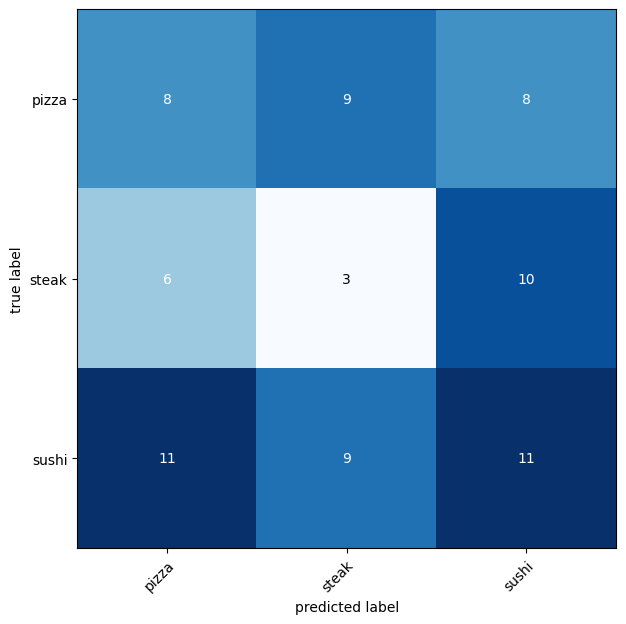

In [21]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confusionmatrix = ConfusionMatrix(task='multiclass',
num_classes=len(class_names))
c_tensor = confusionmatrix(preds=test_preds,
                           target=test_truth)

fig, ax = plot_confusion_matrix(conf_mat=c_tensor.numpy(), # matplotlib likes working with NumPy
                                class_names=class_names,
                                figsize=(10,7))